In [1]:
%run "./utils.ipynb"

Using TensorFlow backend.


# Main configs

In [2]:
loadFromMerged=True
loadFromIndexes= False
Mapper='S'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000
INCLUDE_DIRECTION = True

LOAD_OLD_DATA_TRAIN = False
LOAD_OLD_DATA_TEST = False
MERGE_TESTS=False

TEST_CLASS_CAP =150

pre_Process_remove_empties = False

In [3]:
x= []
y= []

x_test = []
y_test = []
y_test_service= []

x_train = []
y_train = []
y_train_service = []

test_names = []

add_to_trainig = [0,2]

if loadFromMerged:
    print("in load from merged")
    if LOAD_OLD_DATA_TRAIN:
        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_hub_segments_final.json'  ) as f:
            y_data = json.load(f)

        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_pcap_segments_final.json'  ) as f:
            x_data = json.load(f)

    #     with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
    #         y_data = json.load(f)

    #     with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
    #         x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )


        x_train,y_train, y_train_service= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    else:
        
        for pick in sorted(glob.glob( '../files/iot_data_2020/train/hub_segments/*.json' )):
            fname  = os.path.basename(pick)
#             test_names.append( fname )
            with open( os.path.join( '../files/iot_data_2020/train/hub_segments/', fname) ) as f:
                y_data = json.load(f)

            with open( os.path.join('../files/iot_data_2020/train/pcap_segments/', fname) ) as f:
                x_data = json.load(f)

            if len( y_data ) != len(x_data) :
                print( pick )
                continue

            x_t,y_t, y_t_s= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    
            x_train.extend(x_t)
            y_train.extend(y_t)
            y_train_service.extend(y_t_s)
            

    #     continue
#     if loadFromIndexes:
#         print("load from indexes")
#         with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
#             index_info = json.load(f)


#         for i in index_info[FoldID]["test"]:
#             x_test[str(i)]=(x_data[str(i)] )
#             y_test[str(i)]=(y_data[str(i)] )

#         for i in index_info[FoldID]["train"]:
#             x_train[str(i)]=(  x_data[str(i)] )
#             y_train[str(i)]=(  y_data[str(i)] )
        
#         x_test_t,y_test_t= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
#         x_test.append(x_test_t)
#         y_test.append(y_test_t)
    #     else :
    print("loading from test files")
    files_path =  '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/home*.json' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/pcap_segments_final/*.json'
    test_y_dir = '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/hub_segments_final/'
    test_x_dir = '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/pcap_segments_final/'
    
    test_files = sorted(glob.glob(files_path))
    print( "found files : " , len(test_files) )
    
    
    for pick  in test_files:
        fname  = os.path.basename(pick)
        test_names.append( fname )
        print(fname)
        with open( os.path.join(test_y_dir , fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join(test_x_dir, fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper, include_direction= INCLUDE_DIRECTION )

#         if test_files.index(pick) in add_to_trainig:
#             x_test_t,y_test_t, y_test_service_t= clean_data( x_data_test, y_data_test, IgnoreEmpty , Mapping=Mapper)
#             x_train.extend(x_test_t)
#             y_train.extend(y_test_t)
#             y_train_service.extend(y_test_service_t)

                
        if MERGE_TESTS:
            x_test.extend(t_x)
            y_test.extend(t_y)
            y_test_service.extend(t_z)
        else:
            x_test.append(t_x)
            y_test.append(t_y)
            y_test_service.append(t_z)
if MERGE_TESTS:
    x_test = [x_test]
    y_test = [y_test]
    y_test_service = [y_test_service]
    test_names =['MERGED']
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
#     x.extend(t_x)
#     y.extend(t_y)
# else:
#     for pick in sorted(glob.glob( '../files/train/hub_segments/*.json' )):
#         fname  = os.path.basename(pick)
#         test_names.append( fname )
#         with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
#             y_data = json.load(f)

#         with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
#             x_data = json.load(f)

#         if len( y_data ) != len(x_data) :
#             print( pick )
#             continue

#         t_x,t_y= clean_data( x_data, y_data, True, include_direction=INCLUDE_DIRECTION )

#         x.extend( t_x)
#         y.extend(t_y)

x= np.array(x)
y= np.array(y)

# x_train = np.append( x_train, x_test[0] , axis=0)
# x_train = np.append( x_train, x_test[2] , axis=0)

# y_train = np.append( y_train, y_test[0] , axis=0)
# y_train = np.append( y_train, y_test[2] , axis=0)


len(x_train), len(y_test)

in load from merged
2522 2335
0 0
7 6
0 0
9 9
3161 3047
2703 2229
17 17
29 17
2960 2778
1775 1697
15 12
191 143
0 0
10 9
7114 6606
983 652
918 890
1703 1540
7 7
2199 2179
loading from test files
found files :  5
home_os_final.json
18308 18308
home_sk_final.json
5837 5837
test_data_light.json
233 233
test_data_lock.json
807 807
test_data_motion_2.json
8133 8133


(24173, 5)

# sets the classes 

In [4]:
classes = sorted(list(np.unique(  np.concatenate( y_train  ))))
# print([ (i , classes[i]) for i in range( len(classes) ) ])

service_classes = sorted(list(np.unique(  np.concatenate( y_train_service  ))))
[ (i , service_classes[i]) for i in range( len(service_classes) ) ]

[(0, 'acceleration'),
 (1, 'activity'),
 (2, 'battery'),
 (3, 'button'),
 (4, 'colorTemperature'),
 (5, 'contact'),
 (6, 'level'),
 (7, 'lock'),
 (8, 'motion'),
 (9, 'no_logs'),
 (10, 'ping'),
 (11, 'status'),
 (12, 'switch'),
 (13, 'temperature'),
 (14, 'threeAxis'),
 (15, 'unknown'),
 (16, 'water')]

In [5]:
classes

['acceleration',
 'activity',
 'battery',
 'button',
 'colorTemperature',
 'contact',
 'level',
 'lock',
 'motion',
 'no_logs',
 'ping',
 'status',
 'switch',
 'temperature',
 'threeAxis',
 'unknown',
 'water']

## Filter the records by service/event types

choose services to keep : 

In [6]:
if Mapper=='SE':
    services_to_keep = [
        "colorTemperature-XXX",
"contact-closed",
"contact-open",
"level-XXX",
"lock-locked",
"lock-unlocked",
"motion-active",
"motion-inactive",
"ping-ping",
"status-closed",
"status-open",
"switch-off",
"switch-on",
"temperature-XXX"
    ] 
else:
     services_to_keep =["button",
"colorTemperature",
"contact",
"level",
"lock",
"motion",
"ping",
"status",
"switch",
"temperature"]

# keep all ? 
# services_to_keep= classes

find records which need change

In [7]:
train_indexes_to_change =  [ i for i in range(len(y_train)) if
              is_clean( y_train[i],to_keep=services_to_keep, return_clean=False) ] 

y_train = [ ['unknown'] if i in train_indexes_to_change else y_train[i] 
           for i in range(len(y_train)) ] 

for t_index in range(len(y_test)):
    test_indexes_to_change =  [ i for i in range(len(y_test[t_index])) if
                  is_clean( y_test[t_index][i],to_keep=services_to_keep, return_clean=False) ] 

    y_test[t_index] = [ ['unknown'] if i in test_indexes_to_change else y_test[t_index][i] 
               for i in range(len(y_test[t_index])) ] 

In [8]:
def make_known_unknown(inp, unknown_ind):
    return [ [1,0] if (x[unknown_ind] == 1 ) else [0,1]   for x in inp ]

known_unknown_y_train = [ [1,0] if (len(x) == 1 and ("unknown" in x or 'unknown-' in x)) else [0,1]   for x in y_train ]

known_unknown_y_test= [] 

for i in range(len(y_test)):
    
    known_unknown_y_test.append( [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_test[i] ])


remove classes that are ignored from the services list 

In [9]:
classes = services_to_keep
classes.append('unknown')
classes

['button',
 'colorTemperature',
 'contact',
 'level',
 'lock',
 'motion',
 'ping',
 'status',
 'switch',
 'temperature',
 'unknown']

In [10]:
x,y,_=pre_process_raw( x_train, y_train , 15, zero_pad=True, normalize=True, classes=classes, remove_empty=pre_Process_remove_empties)

get the data and preprocess train and test portions

In [11]:
dim_size= 20
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True,remove_empty=pre_Process_remove_empties)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 

In [12]:
len(rf_tests[0][0]), len(x_test[0]), len(y_test[0])

(18308, 18308, 18308)

vectorize the X vars

In [13]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 5))
x_xgb_train = vectorizer.fit_transform(x_random_forest_train)
xgb_test = []
for x in range(len(rf_tests)):
    xgb_test.append( ( vectorizer.transform(rf_tests[x][0]),
                    rf_tests[x][1],
                    rf_tests[x][2]
                  ))
    

# XGBoost 

In [14]:

xgb_known_unknown_separator_classifier = OneVsRestClassifier(XGBClassifier())

xgb_known_unknown_separator_classifier.fit(x_xgb_train, np.array(known_unknown_y_train))

train_known_unknown_pred=xgb_known_unknown_separator_classifier.predict_proba(x_xgb_train)


In [15]:
test_known_unknown_predicted = []
for i in range(len(xgb_test)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    xgb_pred=xgb_known_unknown_separator_classifier.predict( xgb_test[i][0])
    test_known_unknown_predicted.append(xgb_pred)
    print_info( np.array( make_known_unknown(xgb_test[i][1], classes.index('unknown'))), xgb_pred, ["unknown","known"])

==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.731      0.627     0.989     0.767     12983  8143/ 5231/   94/ 4840
                         known     0.731      0.982     0.519     0.680      5325  5231/ 8143/ 4840/   94
------------------------------------------------------------------------
                      AVERAGES     0.731      0.805     0.754     0.724     18308     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.731      0.731     0.852     0.742     18308     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.731      0.982     0.519     0.680     18308     0/    0/    0/    0
----------

In [16]:
len(test_known_unknown_predicted[0]), len(xgb_test[0]), (xgb_test[0][1]).shape

(18308, 3, (18308, 11))

In [17]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_xgb_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

xgb_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    xgb_test_known.append(  (xgb_test[test_index][0][known_indexes], 
                            xgb_test[test_index][1][known_indexes],
                            xgb_test[test_index][2],
                            known_indexes
                           ))

In [18]:
xgb_classifier = OneVsRestClassifier(XGBClassifier())

xgb_classifier.fit(x_xgb_train, np.array(y_random_forest_train))


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='binary:logistic',
                                            

In [19]:
xg_boost_results = []
xgb_preds = []
for i in range(len(xgb_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    xgb_pred= xgb_classifier.predict( xgb_test_known[i][0])
    xgb_pred = add_unknowns_back(xgb_pred,xgb_test[i][1], xgb_test_known[i][3] , classes)
    xgb_preds.append(xgb_pred)
    xg_boost_results.append(print_info( xgb_test[i][1], xgb_pred, classes, confidance=0.8))

==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000      0.750     0.692     0.720        12     9/18292/    4/    3
              colorTemperature     1.000      0.800     1.000     0.889         5     4/18303/    0/    1
                       contact     0.993      0.740     0.552     0.632       150   111/18068/   90/   39
                         level     0.986      0.750     0.056     0.103        20    15/18033/  255/    5
                          lock     1.000      0.941     0.889     0.914        34    32/18270/    4/    2
                        motion     0.975      0.460     0.155     0.232       150    69/17781/  377/   81
                          ping     0.986      0.950     0.998     0.973      4813  4570/13484/   11/  243
                 

/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000      1.000     0.961     0.980        49    49/ 5786/    2/    0
              colorTemperature     1.000      1.000     0.500     0.667         1     1/ 5835/    1/    0
                       contact     0.989      0.733     0.803     0.767       150   110/ 5660/   27/   40
                         level     0.996      0.811     0.754     0.782        53    43/ 5770/   14/   10
                          lock     1.000        nan       nan       nan         0     0/ 5837/    0/    0
                        motion     0.961      0.609     0.315     0.415       133    81/ 5528/  176/   52
                          ping     0.984      0.961     0.997     0.979      2301  2212/ 3529/    7/   89
                        status     0.997      0.863     0.967     0.912       10

Exact Match ACC : 0.64908 
Total Records : 8133 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 1001 (0.123)%


In [20]:
# for i in range(len(rf_test_known)) :
#     print( "==================HOME Case : %s =============" % test_names[ i] )
#     rf_pred= xgb_classifier.predict( rf_test_known[i][0])
#     print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.3)

# Random Forest 

## string encoding test

In [21]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=100, max_depth=400,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_xgb_train, known_unknown_y_train)


In [22]:
train_known_unknown_pred=knownity_rf.predict(x_xgb_train)

In [23]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( xgb_test[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( make_known_unknown(rf_tests[i][1], classes.index('unknown'))), rf_pred, ["unknown","known"])

==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.726      0.621     0.988     0.763     12983  8062/ 5224/  101/ 4921
                         known     0.726      0.981     0.515     0.675      5325  5224/ 8062/ 4921/  101
------------------------------------------------------------------------
                      AVERAGES     0.726      0.801     0.751     0.719     18308     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.726      0.726     0.850     0.737     18308     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.726      0.981     0.515     0.675     18308     0/    0/    0/    0
----------

In [24]:
type(rf_tests[0][1])

numpy.ndarray

In [25]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_xgb_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (xgb_test[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [26]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=400,
                             random_state=0 )
t_hist = clf.fit(x_train_known, y_train_known)


In [27]:
rf_results = []
rf_preds = [] 
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    rf_preds.append(rf_pred)
    rf_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.09))

==================HOME Case : home_os_final.json =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.999      0.000       nan     0.000        12     0/18296/    0/   12
              colorTemperature     1.000      1.000     1.000     1.000         5     5/18303/    0/    0
                       contact     0.990      0.760     0.445     0.562       150   114/18016/  142/   36
                         level     0.984      0.750     0.051     0.095        20    15/18007/  281/    5
                          lock     1.000      0.941     0.865     0.901        34    32/18269/    5/    2
                        motion     0.973      0.453     0.141     0.216       150    68/17745/  413/   82
                          ping     0.986      0.951     0.994     0.972      4813  4579/13467/   28/  234
                        status     0.997      0.846     0.688     0.759       11

/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.992      0.020     1.000     0.040        49     1/ 5788/    0/   48
              colorTemperature     1.000      0.000       nan     0.000         1     0/ 5836/    0/    1
                       contact     0.988      0.747     0.772     0.759       150   112/ 5654/   33/   38
                         level     0.996      0.849     0.726     0.783        53    45/ 5767/   17/    8
                          lock     1.000        nan     0.000     0.000         0     0/ 5835/    2/    0
                        motion     0.961      0.594     0.312     0.409       133    79/ 5530/  174/   54
                          ping     0.985      0.964     0.997     0.980      2301  2218/ 3529/    7/   83
                        status     0.998      0.912     0.959     0.935       10

/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000        nan       nan       nan         0     0/  233/    0/    0
              colorTemperature     0.876      0.065     1.000     0.121        31     2/  202/    0/   29
                       contact     0.996        nan     0.000     0.000         0     0/  232/    1/    0
                         level     0.820      0.902     0.685     0.779        82    74/  117/   34/    8
                          lock     1.000        nan       nan       nan         0     0/  233/    0/    0
                        motion     0.974        nan     0.000     0.000         0     0/  227/    6/    0
                          ping     1.000      1.000     1.000     1.000        26    26/  207/    0/    0
                        status     0.996        nan     0.000     0.000         

In [28]:
# for i in range(len(rf_test_known)) :
#     print( "==================HOME Case : %s =============" % test_names[ i] )
#     rf_pred= clf.predict( rf_test_known[i][0])
#     print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

## Random Forest baseline calc

preproicess the data 

In [29]:
dim_size= 50
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes,remove_empty=pre_Process_remove_empties)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=True, normalize=False, classes=classes, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 

In [30]:
len(rf_tests[0][0]),len( rf_tests[0][1]), len(x_test[0]), len(y_test[0])

(18308, 18308, 18308, 18308)

first stage RF will learn if it is a known or unknown instance 

In [31]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_random_forest_train, known_unknown_y_train)


In [32]:
train_known_unknown_pred=knownity_rf.predict(x_random_forest_train)

In [33]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( make_known_unknown(rf_tests[i][1], classes.index('unknown'))), rf_pred, ["unknown","known"])

==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.733      0.638     0.977     0.772     12983  8279/ 5132/  193/ 4704
                         known     0.733      0.964     0.522     0.677      5325  5132/ 8279/ 4704/  193
------------------------------------------------------------------------
                      AVERAGES     0.733      0.801     0.749     0.724     18308     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.733      0.733     0.845     0.744     18308     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.733      0.964     0.522     0.677     18308     0/    0/    0/    0
----------

In [34]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    print(test_index, max(known_indexes), len(rf_tests[test_index][0]),len(known_indexes))
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][1], 
                           known_indexes))

0 18306 18308 9836
1 5836 5837 3856
2 232 233 154
3 806 807 532
4 8132 8133 4678


# CNN

In [35]:
# create the model
dim_size =20
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes, as_string=True,remove_empty=pre_Process_remove_empties)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes, as_string=True,remove_empty=pre_Process_remove_empties)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 



In [36]:
# known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# # x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
# y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

# lstm_tests_known = [] 

# for test_index in range(len(rf_tests)):
#     known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
#     lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
#                             lstm_tests[test_index][1][known_indexes],
#                             lstm_tests[test_index][2]))

In [37]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_random_forest_train,axis=1)
# x_lstm_prossed_train2 =x_random_forest_train


# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_train_known.reshape((x_train_known.shape[0],x_train_known.shape[1],1))

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [38]:
lstm_tests_known = []
for tt  in range( len(rf_test_known) ):
    lstm_tests_known.append( (rf_test_known[tt][0].reshape(rf_test_known[tt][0].shape[0],
                                                     rf_test_known[tt][0].shape[1],
                                                     1) ,
                           rf_test_known[tt][1],
                           rf_test_known[tt][2] ))

In [39]:
# classes.index('ping'), classes.index('unknown'), len(classes), len(y_lstm_prossed_train[0])
# ping=classes.index('ping')
# unknown =classes.index('unknown')
# key = np.ones_like(y_lstm_prossed_train[0])
# key[unknown]=0
# key[ping]=0
# key

In [40]:
len(x_lstm_prossed_train2),len( y_lstm_prossed_train)

(20012, 24173)

In [41]:
inputs  = Input(  (x_lstm_prossed_train2[0].shape[0]  ,1) )

out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(64,3,padding='same')(out)

dout_1  = Dropout(0.2)(out)
# flt_1   = Flatten()(dout_1)
dense_1 = Dense(32, activation='relu')(dout_1)
# dout_3  = Dropout(0.2)(dense_1)
flt_1   = Flatten()(dense_1)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(flt_1)


model2 = Model(inputs=[inputs], outputs=[out_put_final])


losses = {
    "Event_output": f1_loss_perClass ,
#     "Event_output": f1_loss_perRow 
    "Event_output": "categorical_crossentropy",
}
lossWeights = {"Event_output": 200,
#                "Event_output": 30.0 
    "Event_output": 5
              }
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet_cnn_newloss', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_train_known, epochs=70, batch_size=2000, shuffle=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 128)           512       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            24640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 64)            0   

20012/20012 [==============================] - 0s 12us/step - loss: 2.7213 - f1_perRow: 0.7696 - f1_perClass: 0.5652 - acc: 0.8064
Epoch 47/70
20012/20012 [==============================] - 0s 12us/step - loss: 2.7265 - f1_perRow: 0.7671 - f1_perClass: 0.5542 - acc: 0.8163
Epoch 48/70
20012/20012 [==============================] - 0s 12us/step - loss: 2.7206 - f1_perRow: 0.7596 - f1_perClass: 0.5656 - acc: 0.8185
Epoch 49/70
20012/20012 [==============================] - 0s 12us/step - loss: 2.6934 - f1_perRow: 0.7677 - f1_perClass: 0.5821 - acc: 0.8219
Epoch 50/70
20012/20012 [==============================] - 0s 12us/step - loss: 2.7219 - f1_perRow: 0.7799 - f1_perClass: 0.5697 - acc: 0.8245
Epoch 51/70
20012/20012 [==============================] - 0s 12us/step - loss: 2.6916 - f1_perRow: 0.7746 - f1_perClass: 0.5659 - acc: 0.8261
Epoch 52/70
20012/20012 [==============================] - 0s 12us/step - loss: 2.6472 - f1_perRow: 0.7764 - f1_perClass: 0.5610 - acc: 0.8302
Epoch 53/70

In [42]:

losses = {
    "Event_output": f1_loss_perClass ,
    "Event_output": f1_loss_perRow ,
    "Event_output": "categorical_crossentropy",
}
lossWeights = {
    "Event_output": 300,
               "Event_output": 300.0 ,
    "Event_output": 20
              }
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])


In [43]:
hist2 = model2.fit(x_lstm_prossed_train2, y_train_known, epochs=100, batch_size=7010, shuffle=True, callbacks=callbacks_list)

Epoch 1/100
20012/20012 [==============================] - 1s 50us/step - loss: 10.5708 - f1_perRow: 0.7877 - f1_perClass: 0.5981 - acc: 0.8133
Epoch 2/100
20012/20012 [==============================] - 0s 9us/step - loss: 10.3345 - f1_perRow: 0.7670 - f1_perClass: 0.6039 - acc: 0.8146
Epoch 3/100
20012/20012 [==============================] - 0s 9us/step - loss: 10.3267 - f1_perRow: 0.7853 - f1_perClass: 0.6093 - acc: 0.8186
Epoch 4/100
20012/20012 [==============================] - 0s 9us/step - loss: 10.3214 - f1_perRow: 0.7897 - f1_perClass: 0.6062 - acc: 0.8233
Epoch 5/100
20012/20012 [==============================] - 0s 9us/step - loss: 10.2536 - f1_perRow: 0.7908 - f1_perClass: 0.6063 - acc: 0.8196
Epoch 6/100
20012/20012 [==============================] - 0s 9us/step - loss: 10.2520 - f1_perRow: 0.7871 - f1_perClass: 0.6053 - acc: 0.8170
Epoch 7/100
20012/20012 [==============================] - 0s 9us/step - loss: 10.2097 - f1_perRow: 0.7900 - f1_perClass: 0.6062 - acc: 0.821

20012/20012 [==============================] - 0s 9us/step - loss: 9.7202 - f1_perRow: 0.7813 - f1_perClass: 0.6246 - acc: 0.8196
Epoch 59/100
20012/20012 [==============================] - 0s 9us/step - loss: 9.7476 - f1_perRow: 0.7878 - f1_perClass: 0.6228 - acc: 0.8186
Epoch 60/100
20012/20012 [==============================] - 0s 9us/step - loss: 9.7520 - f1_perRow: 0.7721 - f1_perClass: 0.6232 - acc: 0.8138
Epoch 61/100
20012/20012 [==============================] - 0s 9us/step - loss: 9.7475 - f1_perRow: 0.7734 - f1_perClass: 0.6239 - acc: 0.8143
Epoch 62/100
20012/20012 [==============================] - 0s 9us/step - loss: 9.7513 - f1_perRow: 0.7770 - f1_perClass: 0.6253 - acc: 0.8197
Epoch 63/100
20012/20012 [==============================] - 0s 9us/step - loss: 9.7370 - f1_perRow: 0.7653 - f1_perClass: 0.6211 - acc: 0.8282
Epoch 64/100
20012/20012 [==============================] - 0s 9us/step - loss: 9.7418 - f1_perRow: 0.7825 - f1_perClass: 0.6237 - acc: 0.8217
Epoch 65/100

In [44]:
hist2 = model2.fit(x_lstm_prossed_train2, y_train_known, epochs=200, batch_size=7000, shuffle=True, callbacks=callbacks_list)

Epoch 1/200
20012/20012 [==============================] - 1s 31us/step - loss: 9.6159 - f1_perRow: 0.7869 - f1_perClass: 0.6264 - acc: 0.8219
Epoch 2/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.6034 - f1_perRow: 0.8008 - f1_perClass: 0.6277 - acc: 0.8176
Epoch 3/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.6074 - f1_perRow: 0.7935 - f1_perClass: 0.6273 - acc: 0.8177
Epoch 4/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.6148 - f1_perRow: 0.7889 - f1_perClass: 0.6277 - acc: 0.8266
Epoch 5/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.5807 - f1_perRow: 0.8008 - f1_perClass: 0.6291 - acc: 0.8173
Epoch 6/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.6255 - f1_perRow: 0.8040 - f1_perClass: 0.6285 - acc: 0.8232
Epoch 7/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.5856 - f1_perRow: 0.7902 - f1_perClass: 0.6311 - acc: 0.8310
Epoch

20012/20012 [==============================] - 0s 9us/step - loss: 9.5192 - f1_perRow: 0.8081 - f1_perClass: 0.6320 - acc: 0.8235
Epoch 59/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.5464 - f1_perRow: 0.8125 - f1_perClass: 0.6335 - acc: 0.8274
Epoch 60/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.5120 - f1_perRow: 0.8118 - f1_perClass: 0.6336 - acc: 0.8245
Epoch 61/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.5205 - f1_perRow: 0.7994 - f1_perClass: 0.6343 - acc: 0.8206
Epoch 62/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.4999 - f1_perRow: 0.7969 - f1_perClass: 0.6338 - acc: 0.8197
Epoch 63/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.5221 - f1_perRow: 0.8124 - f1_perClass: 0.6344 - acc: 0.8191
Epoch 64/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.5030 - f1_perRow: 0.8137 - f1_perClass: 0.6308 - acc: 0.8208
Epoch 65/200

20012/20012 [==============================] - 0s 9us/step - loss: 9.4161 - f1_perRow: 0.8074 - f1_perClass: 0.6384 - acc: 0.8312
Epoch 116/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.4169 - f1_perRow: 0.8151 - f1_perClass: 0.6393 - acc: 0.8267
Epoch 117/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.4211 - f1_perRow: 0.8132 - f1_perClass: 0.6395 - acc: 0.8297
Epoch 118/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.4068 - f1_perRow: 0.8093 - f1_perClass: 0.6372 - acc: 0.8291
Epoch 119/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.4265 - f1_perRow: 0.8110 - f1_perClass: 0.6382 - acc: 0.8259
Epoch 120/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.3450 - f1_perRow: 0.8143 - f1_perClass: 0.6395 - acc: 0.8296
Epoch 121/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.3790 - f1_perRow: 0.8095 - f1_perClass: 0.6399 - acc: 0.8338
Epoch 

Epoch 172/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.3400 - f1_perRow: 0.8139 - f1_perClass: 0.6450 - acc: 0.8370
Epoch 173/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.3159 - f1_perRow: 0.8185 - f1_perClass: 0.6458 - acc: 0.8331
Epoch 174/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.3101 - f1_perRow: 0.8211 - f1_perClass: 0.6447 - acc: 0.8282
Epoch 175/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.2809 - f1_perRow: 0.8188 - f1_perClass: 0.6458 - acc: 0.8408
Epoch 176/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.2745 - f1_perRow: 0.8242 - f1_perClass: 0.6478 - acc: 0.8431
Epoch 177/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.2905 - f1_perRow: 0.8225 - f1_perClass: 0.6486 - acc: 0.8406
Epoch 178/200
20012/20012 [==============================] - 0s 9us/step - loss: 9.2827 - f1_perRow: 0.8196 - f1_perClass: 0.6442 - acc:

In [45]:
hist2 = model2.fit(x_lstm_prossed_train2, y_train_known, epochs=300, batch_size=7000, shuffle=True, callbacks=callbacks_list)

Epoch 1/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.2489 - f1_perRow: 0.8232 - f1_perClass: 0.6491 - acc: 0.8291
Epoch 2/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.2688 - f1_perRow: 0.8237 - f1_perClass: 0.6486 - acc: 0.8303
Epoch 3/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.2492 - f1_perRow: 0.8271 - f1_perClass: 0.6506 - acc: 0.8351
Epoch 4/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.2920 - f1_perRow: 0.8270 - f1_perClass: 0.6484 - acc: 0.8311
Epoch 5/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.2477 - f1_perRow: 0.8293 - f1_perClass: 0.6513 - acc: 0.8266
Epoch 6/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.2512 - f1_perRow: 0.8246 - f1_perClass: 0.6522 - acc: 0.8318
Epoch 7/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.2845 - f1_perRow: 0.8270 - f1_perClass: 0.6513 - acc: 0.8285
Epoch 

20012/20012 [==============================] - 0s 9us/step - loss: 9.2136 - f1_perRow: 0.8358 - f1_perClass: 0.6540 - acc: 0.8349
Epoch 59/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.1785 - f1_perRow: 0.8328 - f1_perClass: 0.6547 - acc: 0.8366
Epoch 60/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.1929 - f1_perRow: 0.8344 - f1_perClass: 0.6540 - acc: 0.8340
Epoch 61/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.1679 - f1_perRow: 0.8336 - f1_perClass: 0.6537 - acc: 0.8333
Epoch 62/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.1295 - f1_perRow: 0.8309 - f1_perClass: 0.6547 - acc: 0.8383
Epoch 63/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.1614 - f1_perRow: 0.8361 - f1_perClass: 0.6519 - acc: 0.8374
Epoch 64/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.1582 - f1_perRow: 0.8343 - f1_perClass: 0.6529 - acc: 0.8334
Epoch 65/300

20012/20012 [==============================] - 0s 9us/step - loss: 9.1023 - f1_perRow: 0.8385 - f1_perClass: 0.6571 - acc: 0.8353
Epoch 116/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.1011 - f1_perRow: 0.8367 - f1_perClass: 0.6579 - acc: 0.8340
Epoch 117/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0918 - f1_perRow: 0.8406 - f1_perClass: 0.6579 - acc: 0.8343
Epoch 118/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0817 - f1_perRow: 0.8381 - f1_perClass: 0.6587 - acc: 0.8348
Epoch 119/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0652 - f1_perRow: 0.8394 - f1_perClass: 0.6591 - acc: 0.8332
Epoch 120/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0825 - f1_perRow: 0.8399 - f1_perClass: 0.6567 - acc: 0.8362
Epoch 121/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0872 - f1_perRow: 0.8374 - f1_perClass: 0.6577 - acc: 0.8400
Epoch 

20012/20012 [==============================] - 0s 9us/step - loss: 9.0752 - f1_perRow: 0.8408 - f1_perClass: 0.6558 - acc: 0.8424
Epoch 172/300
20012/20012 [==============================] - 0s 10us/step - loss: 9.0760 - f1_perRow: 0.8402 - f1_perClass: 0.6588 - acc: 0.8339
Epoch 173/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0997 - f1_perRow: 0.8407 - f1_perClass: 0.6573 - acc: 0.8335
Epoch 174/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0989 - f1_perRow: 0.8404 - f1_perClass: 0.6559 - acc: 0.8373
Epoch 175/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0547 - f1_perRow: 0.8392 - f1_perClass: 0.6579 - acc: 0.8361
Epoch 176/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0832 - f1_perRow: 0.8397 - f1_perClass: 0.6560 - acc: 0.8390
Epoch 177/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0764 - f1_perRow: 0.8375 - f1_perClass: 0.6562 - acc: 0.8427
Epoch

20012/20012 [==============================] - 0s 9us/step - loss: 9.0679 - f1_perRow: 0.8387 - f1_perClass: 0.6581 - acc: 0.8366
Epoch 228/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0102 - f1_perRow: 0.8444 - f1_perClass: 0.6592 - acc: 0.8459
Epoch 229/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0414 - f1_perRow: 0.8419 - f1_perClass: 0.6598 - acc: 0.8383
Epoch 230/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0304 - f1_perRow: 0.8429 - f1_perClass: 0.6633 - acc: 0.8351
Epoch 231/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0430 - f1_perRow: 0.8433 - f1_perClass: 0.6636 - acc: 0.8352
Epoch 232/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0520 - f1_perRow: 0.8430 - f1_perClass: 0.6617 - acc: 0.8419
Epoch 233/300
20012/20012 [==============================] - 0s 9us/step - loss: 9.0308 - f1_perRow: 0.8420 - f1_perClass: 0.6629 - acc: 0.8431
Epoch 

20012/20012 [==============================] - 0s 10us/step - loss: 9.0242 - f1_perRow: 0.8420 - f1_perClass: 0.6607 - acc: 0.8415
Epoch 284/300
20012/20012 [==============================] - 0s 10us/step - loss: 9.0541 - f1_perRow: 0.8407 - f1_perClass: 0.6600 - acc: 0.8421
Epoch 285/300
20012/20012 [==============================] - 0s 10us/step - loss: 9.4138 - f1_perRow: 0.8345 - f1_perClass: 0.6524 - acc: 0.8394
Epoch 286/300
20012/20012 [==============================] - 0s 10us/step - loss: 9.4547 - f1_perRow: 0.8381 - f1_perClass: 0.6551 - acc: 0.8415
Epoch 287/300
20012/20012 [==============================] - 0s 10us/step - loss: 9.6580 - f1_perRow: 0.8342 - f1_perClass: 0.6494 - acc: 0.8435
Epoch 288/300
20012/20012 [==============================] - 0s 10us/step - loss: 9.4559 - f1_perRow: 0.8347 - f1_perClass: 0.6548 - acc: 0.8441
Epoch 289/300
20012/20012 [==============================] - 0s 10us/step - loss: 9.3527 - f1_perRow: 0.8398 - f1_perClass: 0.6595 - acc: 0.8422

In [46]:
# model2.load_weights('IoTDownNet_cnn_nocca')

In [47]:
lstm_results = []
lstm_preds = [] 
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    lstm_pred = add_unknowns_back(lstm_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    lstm_preds.append(lstm_pred)
    lstm_results.append(print_info( rf_tests[i][1], lstm_pred, classes, confidance=0.09))

==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.727      0.583     0.001     0.003        12     7/13296/ 5000/    5
              colorTemperature     0.999      1.000     0.333     0.500         5     5/18293/   10/    0
                       contact     0.984      0.733     0.311     0.437       150   110/17914/  244/   40
                         level     0.785      0.600     0.003     0.006        20    12/14352/ 3936/    8
                          lock     0.995      0.853     0.246     0.382        34    29/18185/   89/    5
                        motion     0.755      0.473     0.016     0.031       150    71/13745/ 4413/   79
                          ping     0.986      0.978     0.968     0.973      4813  4705/13338/  157/  108
                 

/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.746      0.633     0.021     0.040        49    31/ 4326/ 1462/   18
              colorTemperature     0.998      0.000     0.000     0.000         1     0/ 5823/   13/    1
                       contact     0.984      0.767     0.653     0.706       150   115/ 5626/   61/   35
                         level     0.798      0.528     0.024     0.045        53    28/ 4631/ 1153/   25
                          lock     0.994        nan     0.000     0.000         0     0/ 5804/   33/    0
                        motion     0.783      0.639     0.065     0.119       133    85/ 4488/ 1216/   48
                          ping     0.990      0.994     0.982     0.988      2301  2287/ 3493/   43/   14
                        status     0.997      0.971     0.884     0.925       10

/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.772        nan     0.000     0.000         0     0/ 6282/ 1851/    0
              colorTemperature     1.000      0.000       nan     0.000         3     0/ 8130/    0/    3
                       contact     0.976      0.023     0.044     0.030       131     3/ 7937/   65/  128
                         level     0.821      0.800     0.003     0.005         5     4/ 6674/ 1454/    1
                          lock     0.981        nan     0.000     0.000         0     0/ 7981/  152/    0
                        motion     0.789      0.440     0.039     0.071       150    66/ 6352/ 1631/   84
                          ping     0.992      0.992     0.983     0.988      2708  2687/ 5378/   47/   21
                        status     0.993        nan     0.000     0.000         

In [48]:
def create_mask(for_classes, classes):
    ret = np.zeros(len(classes))
    
    for x in for_classes:
        ret[classes.index(x)] = 1

    return ret

xgb_classes = [
    'button',
    'level',
 'lock',
 'motion',
    'switch',
 'temperature',
    
 ]
rf_classes =[
   'colorTemperature',
    
]
lstm_classes = [
    'contact',
    'ping',
 'status',
    'unknown'
]


rf_mask =create_mask(rf_classes, classes)
xgb_mask = create_mask(xgb_classes, classes)
lstm_mask = create_mask(lstm_classes, classes)

ensambled_Resutls = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    the_pred = rf_preds[i] * rf_mask + xgb_preds[i] * xgb_mask + lstm_preds[i]* lstm_mask
#     rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
#     rf_preds.append(rf_pred)
    ensambled_Resutls.append( print_info( rf_tests[i][1], the_pred, classes, confidance=0.09))

==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000      0.750     0.692     0.720        12     9/18292/    4/    3
              colorTemperature     1.000      1.000     1.000     1.000         5     5/18303/    0/    0
                       contact     0.984      0.733     0.311     0.437       150   110/17914/  244/   40
                         level     0.986      0.750     0.056     0.103        20    15/18033/  255/    5
                          lock     1.000      0.941     0.889     0.914        34    32/18270/    4/    2
                        motion     0.975      0.460     0.155     0.232       150    69/17781/  377/   81
                          ping     0.986      0.978     0.968     0.973      4813  4705/13338/  157/  108
                 

/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


------------------------------------------------------------------------
                      AVERAGES     0.971      0.666     0.588     0.592      5837     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.954      0.946     0.901     0.915      5837     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.981      0.947     0.882     0.898      5837     0/    0/    0/    0
------------------------------------------------------------------------
 known -ping Weighted AVERAGES     0.948      0.782     0.532     0.585      5837     0/    0/    0/    0
------------------------------------------------------------------------
       non zero count AVERAGES     0.968      0.733     0.646     0.651      5837     0/    0/    0/    0
------------------------------------------------------------------------
Macro F1 : 0.591699
sample F1 : 

Macro F1 : 0.350179
sample F1 : 0.852904
weighted F1 : 0.916209
Exact Match ACC : 0.73122 
Total Records : 8133 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 274 (0.034)%


## Show comparative resutls for xgb and RF

In [49]:
# values, desc = print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

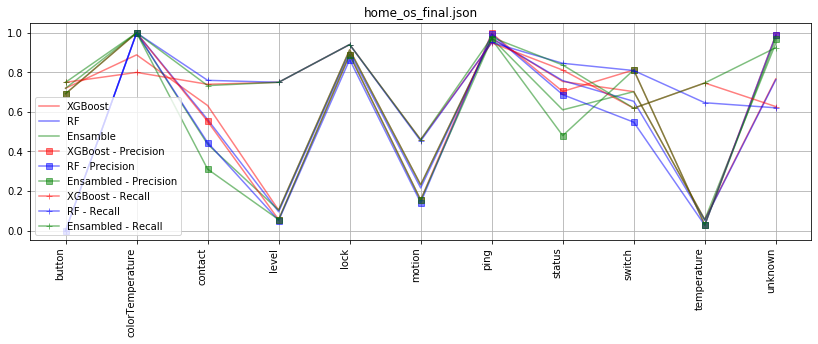

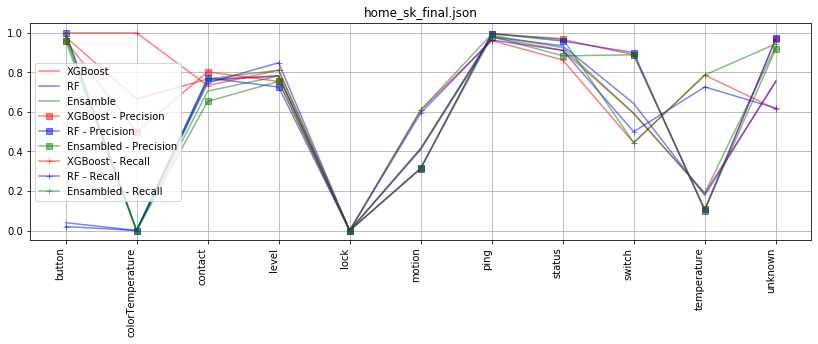

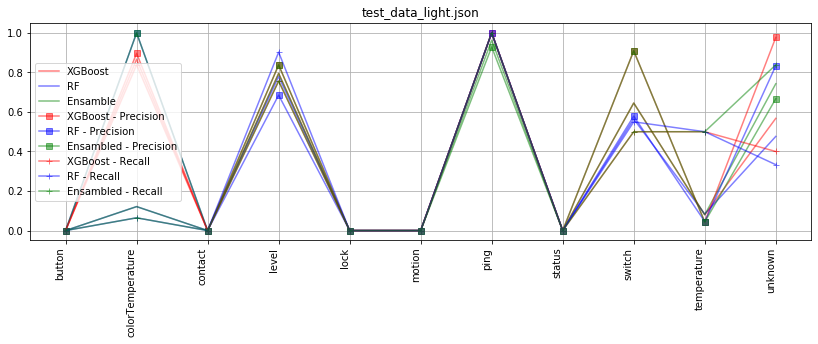

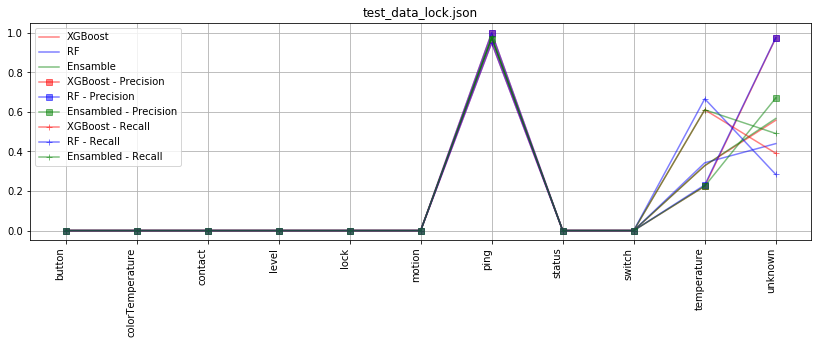

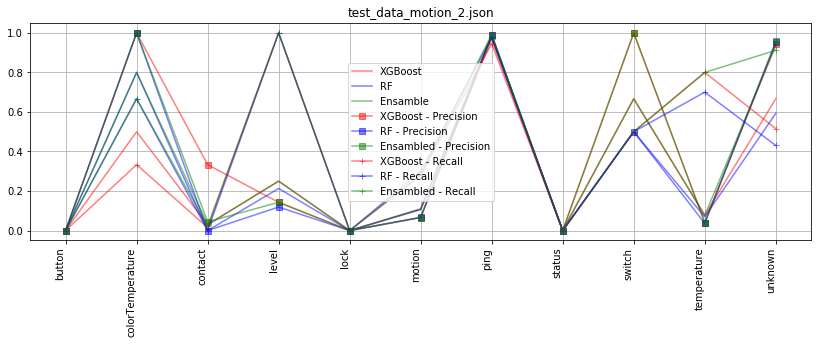

In [50]:
def fix_nan(inp):
    if np.isnan(inp):
        return 0
    else:
        return inp
desc = xg_boost_results[0][1]
index = 0 
for index in range(len(test_names)):
    plt.figure(figsize=(14,4))
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("F Score")]) for x in xg_boost_results[index][0]],
        label="XGBoost",
         color="red" ,
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("F Score")]) for x in rf_results[index][0]],
        label="RF",
         color="blue" ,
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
     [fix_nan(x[desc.index("F Score")]) for x in ensambled_Resutls[index][0]],
    label="Ensamble ",
     color="green" ,
         alpha=0.5
    )
    
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Precision")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Precision",
         color="red" ,
             marker="s",
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("Precision")]) for x in rf_results[index][0]],
        label="RF - Precision",
         color="blue" ,
             marker="s",
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
     [fix_nan(x[desc.index("Precision")]) for x in ensambled_Resutls[index][0]],
    label="Ensambled - Precision",
     color="green" ,
         marker="s",
         alpha=0.5
    )
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Recall")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Recall",
         color="red" ,
             marker="+",
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("Recall")]) for x in rf_results[index][0]],
        label="RF - Recall",
         color="blue" ,
             marker="+",
             alpha=0.5
        )

    plt.plot( [x[0] for x in rf_results[index][0]] , 
     [fix_nan(x[desc.index("Recall")]) for x in ensambled_Resutls[index][0]],
    label="Ensambled - Recall",
     color="green" ,
         marker="+",
         alpha=0.5
    )

    # plt.plot( )
    plt.legend()
    plt.xticks(rotation=90, ha='right')
    plt.title(test_names[ index] )
    plt.grid()

In [51]:
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
allDone()

In [ ]:
assert(False)

In [ ]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.3)


In [ ]:
K.clear_session()

In [ ]:
lstm_tests_known[0][0][0]

In [ ]:
def describe_output(classes, instance):
    ret = [] 
    for x in range(len(instance)):
        if instance[x] > 0.6:
            ret.append(classes[x])
    return ret
def save_resutls(inp, y, y_hat, classes,the_name):
    items = [] 
    for i in range(len(inp)):
#         print(describe_output(classes, y[i]))
        items.append({'inp': str(list(inp[i])),
                     'true': list(describe_output(classes, y[i])),
                     'pred': list(describe_output(classes, y_hat[i]))
                     })
#         print(items[-1])
#         return
    with open('cnn_for_karthika_'+the_name +'.json', 'w') as outfile:
        json.dump(items, outfile)

In [ ]:
describe_output(['a','b'],[1,0])

In [ ]:
lstm_pred = []
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( rf_test_known[i][0])
#     save_resutls( lstm_tests_known[i][0], rf_test_known[i][1], lstm_pred,  classes, test_names[i] )
#     break 
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( rf_test_known[i][1], lstm_pred, classes , confidance=0.5)

In [ ]:
save_resutls( lstm_tests_known[0][0], rf_test_known[0][1], lstm_pred, classes, test_names[0] )

In [ ]:
describe_output(classes, rf_test_known[0][1][0])

## LSTM


In [ ]:
inputs  = Input(  (x_lstm_prossed_train2[0].shape[0]  ,1) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(64,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(30 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(64, activation='relu')  (lstm_1)
lstm_1 =  Dense(32, activation='relu')(bi_d_1)
lstm_2 = Dense(16, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(16, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
# lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

# bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
# lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
# lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

# dout_1  = Dropout(0.1)(lstm_raw_2)
# flt_1   = Flatten()(dout_1)
# dense_1 = Dense(128, activation='relu')(flt_1)
# dout_3  = Dropout(0.2)(dense_1)





# out = Conv1D(128,3,padding='same')(inputs)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)
# # out = Flatten()(out)
# # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


# out = Conv1D(128,3,padding='same')(out)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)
# # out = Flatten()(out)
# # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


# out = Conv1D(128,3,padding='same')(out)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)


# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

# fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
# out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')
# out_new = concatenate( [dout_2] , name='mergerguy')

# dens_out_1 = Dense( 128, activation='relu' )(out_new)
# dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
# dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dout_2)

# toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
# toService_1 = Dense( 130, name="to_service2" )(toService_1)

# service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[out_put_final])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "Event_output": f1_loss_perRow ,
    "Event_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "Event_output": 30.0 ,
    "Event_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=80, batch_size=70, shuffle=True, callbacks=callbacks_list)

In [ ]:
K.clear_session()

In [ ]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( rf_test_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( rf_test_known[i][1], lstm_pred, classes , confidance=0.7)

# LSTM 

In [ ]:
# create the model
dim_size =15
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes,remove_empty=pre_Process_remove_empties)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes,remove_empty=pre_Process_remove_empties)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 



In [ ]:
# known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
# y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

lstm_tests_known = [] 

for test_index in range(len(lstm_tests)):
#     known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    lstm_tests_known.append(  (lstm_tests[test_index][0], 
                            lstm_tests[test_index][1],
                            lstm_tests[test_index][2]))

In [ ]:
# known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
# y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

# lstm_tests_known = [] 

# for test_index in range(len(rf_tests)):
#     known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
#     lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
#                             lstm_tests[test_index][1][known_indexes],
#                             lstm_tests[test_index][2]))

In [ ]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_lstm_prossed_train,axis=1)

for tt  in range( len(lstm_tests_known) ):
    lstm_tests_known[tt]= (lstm_tests_known[tt][0].reshape(len(lstm_tests_known[tt][0]),dim_size,1) ,
                           lstm_tests_known[tt][1],
                           lstm_tests_services[tt][1] )
# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_lstm_prossed_train.reshape(len(x_lstm_prossed_train),dim_size,1)

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE
model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perClass(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perRow(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perRow(y_true, y_pred):
    
#     y_true = y_true * 
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1) 
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1) 
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1) 
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1) 

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perClass(y_true, y_pred):
#     key = K.variable([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.])
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = (2*p*r / (p+r+K.epsilon())) #*key
    
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

In [ ]:
len(x_train)

In [ ]:
inputs  = Input( ( dim_size,1 ) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

 
weights = [
1.0/(57.0 / len(y_train)),
1.0/(19.0 / len(y_train)),
1.0/(7.0 / len(y_train)),
1.0/(14.0 / len(y_train)),
1.0/(6.0 / len(y_train)),
1.0/(176.0 / len(y_train)),
1.0/(27.0 / len(y_train)),
1.0/(35.0 / len(y_train)),
1.0/(371.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
1.0/(4842.0 / len(y_train)),
1.0/(119.0 / len(y_train)),
1.0/(21.0 / len(y_train)),
1.0/(1168.0 / len(y_train)),
1.0/(63.0 / len(y_train)),
1.0/(13305.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
]
    


# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
    "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {"service_output": 200,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('lstm_IoTDownNet_old_data', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=7000, shuffle=True, callbacks=callbacks_list)

In [ ]:
# print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=20, batch_size=5000, shuffle=True, callbacks=callbacks_list)



In [ ]:
model2.load_weights('lstm_IoTDownNet_old_data')

In [ ]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.01)

In [ ]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.7)

In [ ]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)

In [ ]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)







dens_out_3 = Dense( 128, activation='relu' )(dout_2)


# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


#model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=1000, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )






out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)


dens_out_3 = Dense( 128, activation='relu' )(fl_out_cnn)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1)) 

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))



inputs  = Input( ( dim_size,1 ) )







# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [ fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)



service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(dens_out_3)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perClass ,
#     "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
#     "service_output": 20
}
 


model2.compile(loss=losses, loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=1e-6  ), metrics=[f1_perRow,f1_perClass,'acc'])


In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(inputs)
lstm_2 = LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(lstm_1)

lstm_2=Flatten()(lstm_2)
lstm_2 = Dense(256, activation='relu')(lstm_2)




service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(lstm_2)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())

hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)



In [ ]:
#split model
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

#splitting data
X=x_lstm_prossed_train2
y=y_lstm_prossed_train
a,b,c,d,e,f,g,h,ii,jj,k,l,m,n,o,p=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
print(len(y_lstm_prossed_train[0]))
for i in range(0,len(y_lstm_prossed_train)):
    a.append(y_lstm_prossed_train[i][0])
    b.append(y_lstm_prossed_train[i][1])
    c.append(y_lstm_prossed_train[i][2])
    d.append(y_lstm_prossed_train[i][3])
    e.append(y_lstm_prossed_train[i][4])
    f.append(y_lstm_prossed_train[i][5])
    g.append(y_lstm_prossed_train[i][6])
    h.append(y_lstm_prossed_train[i][7])
    ii.append(y_lstm_prossed_train[i][8])
    jj.append(y_lstm_prossed_train[i][9])
    k.append(y_lstm_prossed_train[i][10])
    l.append(y_lstm_prossed_train[i][11])
    m.append(y_lstm_prossed_train[i][12])
    n.append(y_lstm_prossed_train[i][13])
    o.append(y_lstm_prossed_train[i][14])
    p.append(y_lstm_prossed_train[i][15])
    
zzzz=[]    
zzzz.append(np.array(a))
zzzz.append(np.array(b))
zzzz.append(np.array(c))
zzzz.append(np.array(d))
zzzz.append(np.array(e))
zzzz.append(np.array(f))
zzzz.append(np.array(g))
zzzz.append(np.array(h))
zzzz.append(np.array(ii))
zzzz.append(np.array(jj))
zzzz.append(np.array(k))
zzzz.append(np.array(l))
zzzz.append(np.array(m))
zzzz.append(np.array(n))
zzzz.append(np.array(o))
zzzz.append(np.array(p))


for i in range(0,16):
    
    
        
        
    


    inputs  = Input( ( dim_size,1 ) )


    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
    # lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_1 =  Dense(128, activation='relu')(bi_d_1)
    lstm_2 = Dense(128, activation='relu')(lstm_1)



    # td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
    # dout_1  = Dropout(0.1)(td_1)
    dout_1  = Dropout(0.1)(lstm_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_2  = Dropout(0.2)(dense_1)





    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
    # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
    lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

    dout_1  = Dropout(0.1)(lstm_raw_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_3  = Dropout(0.2)(dense_1)





    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)



    # fl_out_1 = Flatten()(dout_2)

    fl_out_cnn = Flatten()(out)

    # out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
    out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

    dens_out_1 = Dense( 128, activation='relu' )(out_new)
    dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
    dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

    # fl2  = Flatten()(out_new)

    out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

    toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
    toService_1 = Dense( 130, name="to_service2" )(toService_1)

    service_output = Dense(1, activation="sigmoid", name = 'service_output')(toService_1)


    losses = {
    #     "service_output": f1_loss_perClass ,
        "service_output": f1_loss_perRow ,
        "service_output": "binary_crossentropy",
    }
    lossWeights = {#"service_output": 20,
                   "service_output": 30.0 ,
        "service_output": 20}




    model2 = Model(inputs=[inputs], outputs=[service_output])
    model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
    # model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    hist2 = model2.fit(x_lstm_prossed_train2, zzzz[i], epochs=200, batch_size=12500, shuffle=True, callbacks=callbacks_list)
    model2.save('number'+str(i)+'.h5')


In [ ]:
# model2.compile(loss=losses,loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=5e-5  ), metrics=[f1_perRow,f1_perClass,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=16500, shuffle=True)


In [ ]:
model2.compile(loss=f1_loss, optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=[f1,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=7500, shuffle=True)

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=3500, shuffle=True)

In [ ]:
model2.save( "LSTM-sigmoid-withRemovedClasses" )

In [ ]:
plt.plot(hist2.history['loss'], c='red')
plt.plot(hist2.history['acc'], c='blue')

In [ ]:
plt.plot(hist2.history['loss'], c='red')
# plt.plot(hist2.history['acc'], c='blue')

In [ ]:
from keras.utils import plot_model
plot_model(model2, to_file='model.png')

In [ ]:
# from keras.models import load_model
# model2=load_model( "LSTM_withSigmoid_LargeData_F1_E100_B500_MSE_False"  
#            )

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    makeReadable( classes=classes, confidance=0.5,data=lstm_tests[i][0],gt=lstm_tests[i][1],model=model2,path=test_names[i],x=lstm_tests[i][0])
    
#     lstm_pred= model2.predict( lstm_tests[i][0])
    


# ------------- do not go any further :) ------

In [ ]:
lstm_pred= model2.predict( lstm_tests[i][0])

In [ ]:
lstm_pred= model2.predict( lstm_tests[1][0])
lstm_pred__ = np.array(list(lstm_pred))

In [ ]:
lstm_pred__ = np.array(list(lstm_pred))
print_info( lstm_tests[1][1], lstm_pred__, classes , confidance=0.43)

In [ ]:
# for i in [1] :
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)
    

In [ ]:
for i in [1] :
# for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.992)
    



In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test2)


In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.60)

In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
print_info(y_lstm_prossed_train, y_lstm_prossed_train, classes, confidance=0.60)

In [ ]:
[x for x  in lstm_pred  if  np.sum(x) > 0 ]

In [ ]:
model2.save( "LSTM_withSigmoid_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )

In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
# x_train_muhammed,y_train_muhammed, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
# x_test_muhammed,y_test_muhammed, classes = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
pred[:10]

In [ ]:
print_info(y_lstm_prossed_test, pred, classes)

In [ ]:
pred[0]

In [ ]:
len( y_lstm_prossed_train[0] )

In [ ]:
dim_size =160
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False,classes=classes,remove_empty=pre_Process_remove_empties)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, , class_cap=TEST_CLASS_CAPnormalize=False,classes=classes,remove_empty=pre_Process_remove_empties)

In [ ]:
len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1]), len(y_lstm_prossed_test  ) , len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1])/len(y_lstm_prossed_test  ) *1.0

In [ ]:
[ x for x  in  pred if np.sum(x) > 1]

In [ ]:
len(y_lstm_prossed_test)

In [ ]:
def do_for_raun( pred   ):
    pp = pred
    pp[pp>=0.5] = 1
    pp[pp<0.5] = 0
    return pp

In [ ]:
len([x for x in pred if np.sum( do_for_raun(x) )==0 ])

In [ ]:
len([x for x in pred if  do_for_raun(x)[20] ==1 or do_for_raun(x)[21] ==1 ])

In [ ]:

# np.save("../files/muhammed/x_train.json" , x_train_muhammed)
# np.save("../files/muhammed/y_train.json", )


# np.save( "../files/muhammed/x_train.json", x_train_muhammed )
# np.save("../files/muhammed/y_train.json",  y_train_muhammed )
# np.save( "../files/muhammed/x_test.json",x_test_muhammed )
# np.save( "../files/muhammed/y_test.json",y_test_muhammed )
# np.save( "../files/muhammed/classes.json",  classes )


In [ ]:
len(x_lstm_prossed_test) + len(x_lstm_prossed_train)